# Food Deserts, Socioeconomic Factors, and Obesity Rates Across U.S. Counties

Obesity is a complex public health issue influenced by a combination of behavioral, environmental, and socioeconomic factors. One area of particular interest is the role of food deserts (geographic areas with limited access to affordable and nutritious food) in shaping dietary patterns and health outcomes. Communities experiencing higher levels of food insecurity or limited access to healthy food options may face an increased risk of obesity.

This project investigates the relationship between socioeconomic indicators, food desert components, and obesity rates. It aims to answer, How do socioeconomic factors and elements of food deserts relate to obesity rates? Multiple modeling approaches were applied, including stepwise regression and elastic net regression, to identify key predictors while addressing multicollinearity. Principal Component Analysis (PCA) was also explored to determine whether dimensionality reduction could improve model performance. The goal of this analysis is to quantify how different aspects of the food environment and socioeconomic context contribute to obesity risk.

Data for this project were sourced from the USDA Food Environment Atlas, which compiles a wide range of indicators across categories such as health, food insecurity, socioeconomic status, retail stores, local access, and food assistance programs. Since the dataset contains measurements from multiple years, predictor variables were lagged to examine their association with obesity rates in 2022. 

## Imports

Import required libraries:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import plotly.offline as po
import plotly.graph_objs as pg
from functools import reduce
from scipy.stats import zscore
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.linear_model import ElasticNetCV
sns.set_style("whitegrid")
%pip install mlxtend

Note: you may need to restart the kernel to use updated packages.


Load Food Environment Atlas from USDA saved in Github repo. The data consists of multiple spreadsheets with the categories health, insecurity, socioeconomic, stores, local, access, assistance. 

## Get Data

In [2]:
health_url = 'https://github.com/elarson5/Food-Deserts-and-Health-Outcomes/raw/refs/heads/master/data/usda_health.xlsx'
health = pd.read_excel(health_url)

insecurity_url = 'https://github.com/elarson5/Food-Deserts-and-Health-Outcomes/raw/refs/heads/master/data/usda_insecurity.xlsx'
insecurity = pd.read_excel(insecurity_url)

socioeconomic_url = 'https://github.com/elarson5/Food-Deserts-and-Health-Outcomes/raw/refs/heads/master/data/usda_socioeconomic.xlsx'
socioeconomic = pd.read_excel(socioeconomic_url)

stores_url = 'https://github.com/elarson5/Food-Deserts-and-Health-Outcomes/raw/refs/heads/master/data/usda_stores.xlsx'
stores = pd.read_excel(stores_url)

access_url = 'https://github.com/elarson5/Food-Deserts-and-Health-Outcomes/raw/refs/heads/master/data/usda_access.xlsx'
access = pd.read_excel(access_url)

assistance_url = 'https://github.com/elarson5/Food-Deserts-and-Health-Outcomes/raw/refs/heads/master/data/usda_assistance.xlsx'
assistance = pd.read_excel(assistance_url)

### Subset Data
Retain only the variables of interest from each data frame as well as FIPS and State for merging and other data processing. 

In [3]:
health_df = health[["FIPS", "State", "PCT_OBESE_ADULTS22"]]

In [4]:
insecurity_df = insecurity[["FIPS", "State", 
                "FOODINSEC_18_20", "VLFOODSEC_18_20"]]

In [5]:
socio_df = socioeconomic[[
    "FIPS",
    "State",
    "MEDHHINC21",
    "POVRATE21",
    "PCT_65OLDER20"
]]

In [6]:
stores_df = stores[[
    "FIPS",
    "State",
    "GROCPTH20",
    "SUPERCPTH20",
    "CONVSPTH20",
    "SPECSPTH20",
    "SNAPSPTH17",
    "WICSPTH16"
]]

In [7]:
access_df = access[['FIPS', 'State', 'PCT_LACCESS_LOWI19', 'PCT_LACCESS_HHNV19']]

In [8]:
assistance_df= assistance[['FIPS', 'State', 'REDEMP_SNAPS17', 'FOOD_BANKS21']]

### Merge Data
Combine the data frames based on FIPS and State. FIPS codes are standardized numerical codes used to identify geographic areas, such as states, counties, and cities established by NIST, National Institute of Standards and Technology.

In [9]:
dfs = [health_df, insecurity_df, socio_df, stores_df, access_df, assistance_df]

In [10]:
df = reduce(lambda left, right: pd.merge(left, right, on=['FIPS', 'State'], how='left'), dfs)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3144 entries, 0 to 3143
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   FIPS                3144 non-null   int64  
 1   State               3144 non-null   object 
 2   PCT_OBESE_ADULTS22  3144 non-null   float64
 3   FOODINSEC_18_20     3143 non-null   float64
 4   VLFOODSEC_18_20     3143 non-null   float64
 5   MEDHHINC21          3144 non-null   int64  
 6   POVRATE21           3144 non-null   float64
 7   PCT_65OLDER20       3144 non-null   float64
 8   GROCPTH20           3144 non-null   float64
 9   SUPERCPTH20         3144 non-null   float64
 10  CONVSPTH20          3144 non-null   float64
 11  SPECSPTH20          3144 non-null   float64
 12  SNAPSPTH17          3144 non-null   float64
 13  WICSPTH16           3144 non-null   float64
 14  PCT_LACCESS_LOWI19  3144 non-null   float64
 15  PCT_LACCESS_HHNV19  3144 non-null   float64
 16  REDEMP

### Rename Data
Rename each variable into simpler names. Then view basic summary statistics of variables.

In [12]:
low_income_access = "low_income_access_2019"
no_car_access = "no_car_access_2019"
grocery_stores = "grocery_stores_2020"
supercenters = "supercenters_2020"
convenience_stores = "convenience_stores_2020"
specialized_food_stores = "specialized_food_stores_2020"
snap_stores = "snap_stores_2017"
wic_stores = "wic_stores_2016"
snap_redemptions = "snap_redemptions_2017"
food_banks = "food_banks_2021"
food_insecurity_rate = "food_insecurity_rate_2018_thru_2020"
very_low_food_security_rate = "very_low_food_security_rate_2018_thru_2020"
percent_obesity = "percent_obesity_2022"
percent_65_plus = "sixtyfive_plus_2020"
median_income = "median_income_2021"
poverty_rate = "poverty_2021"
obesity = "percent_obesity_2022"
diabetes = "percent_diabetes_2019"
rename = {
    "PCT_LACCESS_LOWI19": low_income_access,
    "PCT_LACCESS_HHNV19": no_car_access,
    "GROCPTH20": grocery_stores,
    "SUPERCPTH20": supercenters,
    "CONVSPTH20": convenience_stores,
    "SPECSPTH20": specialized_food_stores,
    "SNAPSPTH17": snap_stores,
    "WICSPTH16": wic_stores,
    "REDEMP_SNAPS17": snap_redemptions,
    "FOOD_BANKS21": food_banks,
    "FOODINSEC_18_20": food_insecurity_rate,
    "VLFOODSEC_18_20": very_low_food_security_rate,
    "PCT_OBESE_ADULTS22": obesity,
    "PCT_65OLDER20": percent_65_plus,
    "MEDHHINC21": median_income,
    "POVRATE21": poverty_rate
}
df = df.rename(columns=rename)

So far the variables in the dataset are:

- FIPS
- State
- low_income_access_2019: Low income & low access to store (%), 2019
- no_car_access_2019: Households, no car & low access to store (%), 2019
- grocery_stores_2020: Grocery stores/1,000 pop in 2020
- supercenters_2020: Supercenters and club stores in 2020, count
- convenience_stores_2020: Convenience stores/1,000 pop in 2020
- specialized_food_stores_2020: Specialised food stores/1,000 pop in 2020
- snap_stores_2017: SNAP-authorized stores/1,000 pop in 2017
- wic_stores_2016: WIC-authorized stores/1,000 pop in 2016
- snap_redemptions: SNAP redemptions/SNAP-authorized stores in 2017, Dollars/store
- food_banks_2021: Number of food banks in 2021, count
- food_insecurity_rate_2018_thru_2020: Household food insecurity (%, three-year average), 2018-2020
- very_low_food_security_rate_2018_thru_2020: Household very low food security (%, three-year average), 2018-2020
- sixtyfive_plus_2020: % Population 65 years or older, 2020
- median_income_2021: Median household income in 2021, dollars
- poverty_2021: Poverty rate, 2021, percent
- percent_obesity_2022: Adults obesity rate in 2019, percent

## Explore Data

In [13]:
df.describe()

,FIPS,percent_obesity_2022,food_insecurity_rate_2018_thru_2020,very_low_food_security_rate_2018_thru_2020,median_income_2021,poverty_2021,sixtyfive_plus_2020,grocery_stores_2020,supercenters_2020,convenience_stores_2020,specialized_food_stores_2020,snap_stores_2017,wic_stores_2016,low_income_access_2019,no_car_access_2019,snap_redemptions_2017,food_banks_2021
count,3144.000000,3144.000000,3143.000000,3143.000000,3144.000000,3144.000000,3144.000000,3144.000000,3144.000000,3144.000000,3144.000000,3144.000000,3144.000000,3144.000000,3144.000000,3144.000000,3144.000000
mean,30365.634542,32.385337,11.094337,4.357906,58898.131361,8.593257,17.308879,-2893.598863,-7851.907907,-905.522436,-6484.336227,-87.432638,-498.391133,-0.750239,-6.058792,178623.695426,-9.101145
std,15174.497197,159.173921,2.175232,0.913503,15359.949393,238.989659,158.941087,4534.885278,4106.222116,2870.374284,4774.377370,932.572788,2175.408772,298.128727,297.887205,113115.078860,297.778608
min,1001.000000,-8888.000000,5.700000,2.300000,-9999.000000,-9999.000000,-8888.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000
25%,18174.500000,33.400000,9.700000,3.800000,49002.000000,10.600000,17.240447,-9999.000000,-9999.000000,0.353378,-9999.000000,0.674345,0.111735,3.655029,1.607701,99028.210790,0.000000
50%,29174.000000,35.500000,11.200000,4.400000,56629.000000,13.600000,19.784419,0.141789,-9999.000000,0.492827,-9999.000000,0.860191,0.165481,6.687809,2.540787,177285.186248,0.000000
75%,45079.500000,37.700000,12.600000,5.000000,65683.750000,17.525000,22.626233,0.216868,-9999.000000,0.666688,0.051036,1.101520,0.251625,10.872572,3.880950,247745.821561,0.000000
max,56045.000000,41.000000,15.300000,6.500000,153716.000000,43.900000,58.859979,2.335357,0.180072,4.441977,0.635324,5.902454,3.095975,62.599918,54.574402,858017.806533,2.000000


In the row for minimum values, there are values -8888, -9999. Per the data source, -9999, -8888, and NaN values are used for missing values. The first step to address this is replacing -9999 and -8888 with NaN. 

In [14]:
df.replace([-9999, -8888], np.nan, inplace=True)

In [15]:
df.describe()

,FIPS,percent_obesity_2022,food_insecurity_rate_2018_thru_2020,very_low_food_security_rate_2018_thru_2020,median_income_2021,poverty_2021,sixtyfive_plus_2020,grocery_stores_2020,supercenters_2020,convenience_stores_2020,specialized_food_stores_2020,snap_stores_2017,wic_stores_2016,low_income_access_2019,no_car_access_2019,snap_redemptions_2017,food_banks_2021
count,3144.000000,3143.000000,3143.000000,3143.000000,3142.000000,3142.000000,3143.000000,2234.000000,675.000000,2859.000000,1105.000000,3116.000000,2987.000000,3141.000000,3141.000000,2895.000000,3141.000000
mean,30365.634542,35.223513,11.094337,4.357906,58941.633355,14.609866,20.142257,0.225683,0.031914,0.574138,0.087695,0.918417,0.227412,8.445479,3.131856,194846.434342,0.086597
std,15174.497197,3.266036,2.175232,0.913503,15267.686038,5.663115,4.704975,0.178522,0.014662,0.278875,0.067549,0.372232,0.198804,7.430106,2.974417,102819.003202,0.286893
min,1001.000000,24.300000,5.700000,2.300000,25653.000000,2.900000,4.798745,0.037616,0.003748,0.129240,0.015244,0.040180,0.005036,0.000000,0.000000,8375.216000,0.000000
25%,18174.500000,33.400000,9.700000,3.800000,49016.250000,10.600000,17.242008,0.134743,0.023211,0.395288,0.049351,0.678890,0.119396,3.669639,1.612652,120103.924821,0.000000
50%,29174.000000,35.500000,11.200000,4.400000,56634.000000,13.600000,19.785063,0.179095,0.029500,0.521584,0.069428,0.863784,0.171769,6.696394,2.541467,187396.799360,0.000000
75%,45079.500000,37.700000,12.600000,5.000000,65687.250000,17.575000,22.627022,0.256055,0.037449,0.690926,0.103413,1.102872,0.259528,10.882041,3.881178,253610.676340,0.000000
max,56045.000000,41.000000,15.300000,6.500000,153716.000000,43.900000,58.859979,2.335357,0.180072,4.441977,0.635324,5.902454,3.095975,62.599918,54.574402,858017.806533,2.000000


The values -8888 and -9999 have been replaced with NaN. The next step is to perform imputation to replace the missing values with mean values. This project chose to do mean imputation at the state level.

## Impute Data

In [16]:
impute = [c for c in df.columns if c not in ['FIPS', 'State'] and pd.api.types.is_numeric_dtype(df[c])]

In [17]:
df[impute] = df.groupby('State')[impute].transform(lambda x: x.fillna(x.mean()))

In [18]:
df.info()
df.describe().T
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3144 entries, 0 to 3143
Data columns (total 18 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   FIPS                                        3144 non-null   int64  
 1   State                                       3144 non-null   object 
 2   percent_obesity_2022                        3144 non-null   float64
 3   food_insecurity_rate_2018_thru_2020         3144 non-null   float64
 4   very_low_food_security_rate_2018_thru_2020  3144 non-null   float64
 5   median_income_2021                          3144 non-null   float64
 6   poverty_2021                                3144 non-null   float64
 7   sixtyfive_plus_2020                         3144 non-null   float64
 8   grocery_stores_2020                         3144 non-null   float64
 9   supercenters_2020                           3144 non-null   float64
 10  convenience_

FIPS                                          0
State                                         0
percent_obesity_2022                          0
food_insecurity_rate_2018_thru_2020           0
very_low_food_security_rate_2018_thru_2020    0
median_income_2021                            0
poverty_2021                                  0
sixtyfive_plus_2020                           0
grocery_stores_2020                           0
supercenters_2020                             0
convenience_stores_2020                       0
specialized_food_stores_2020                  0
snap_stores_2017                              0
wic_stores_2016                               0
low_income_access_2019                        0
no_car_access_2019                            0
snap_redemptions_2017                         0
food_banks_2021                               0
dtype: int64

Due to performing imputation at the state level, some NaN values were missed and remain in the data. Because they account for a small percent of the data, the remaining rows with missing values will be dropped using the code below.

In [19]:
df = df.dropna(subset=[
    food_insecurity_rate,
    very_low_food_security_rate,
    snap_stores,
    wic_stores
])

In [20]:
df.info()
df.describe().T
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3144 entries, 0 to 3143
Data columns (total 18 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   FIPS                                        3144 non-null   int64  
 1   State                                       3144 non-null   object 
 2   percent_obesity_2022                        3144 non-null   float64
 3   food_insecurity_rate_2018_thru_2020         3144 non-null   float64
 4   very_low_food_security_rate_2018_thru_2020  3144 non-null   float64
 5   median_income_2021                          3144 non-null   float64
 6   poverty_2021                                3144 non-null   float64
 7   sixtyfive_plus_2020                         3144 non-null   float64
 8   grocery_stores_2020                         3144 non-null   float64
 9   supercenters_2020                           3144 non-null   float64
 10  convenience_

FIPS                                          0
State                                         0
percent_obesity_2022                          0
food_insecurity_rate_2018_thru_2020           0
very_low_food_security_rate_2018_thru_2020    0
median_income_2021                            0
poverty_2021                                  0
sixtyfive_plus_2020                           0
grocery_stores_2020                           0
supercenters_2020                             0
convenience_stores_2020                       0
specialized_food_stores_2020                  0
snap_stores_2017                              0
wic_stores_2016                               0
low_income_access_2019                        0
no_car_access_2019                            0
snap_redemptions_2017                         0
food_banks_2021                               0
dtype: int64

The output above confirms there are now no missing (NaN) values. 

<!---I DON'T AGREE

<!--- The project wanted to capture as many measurements as possible regarding grocery store access. However, having this number of measurements of grocery stores presents challenges. Two new variables, total_stores and assistance_stores, were generated to consolidate the grocery store variables.

<!---Confirm the new variables successfully integrated into the dataset. Note that the count remains 3115.

At this stage, the attributes of FIPS and State are no longer needed in the dataset as they were used to merge the datasets but are not being analyzed for their impact on obesity.

In [21]:
store_cols_to_drop = [
    "State",
    "FIPS"
]

In [22]:
df = df.drop(columns=store_cols_to_drop)

In [23]:
df.columns

Index(['percent_obesity_2022', 'food_insecurity_rate_2018_thru_2020',
       'very_low_food_security_rate_2018_thru_2020', 'median_income_2021',
       'poverty_2021', 'sixtyfive_plus_2020', 'grocery_stores_2020',
       'supercenters_2020', 'convenience_stores_2020',
       'specialized_food_stores_2020', 'snap_stores_2017', 'wic_stores_2016',
       'low_income_access_2019', 'no_car_access_2019', 'snap_redemptions_2017',
       'food_banks_2021'],
      dtype='object')

### Visualize Data
#### Correlation Heat Maps
Heatmaps can be used to perform initial exploration of the correlation between variables.

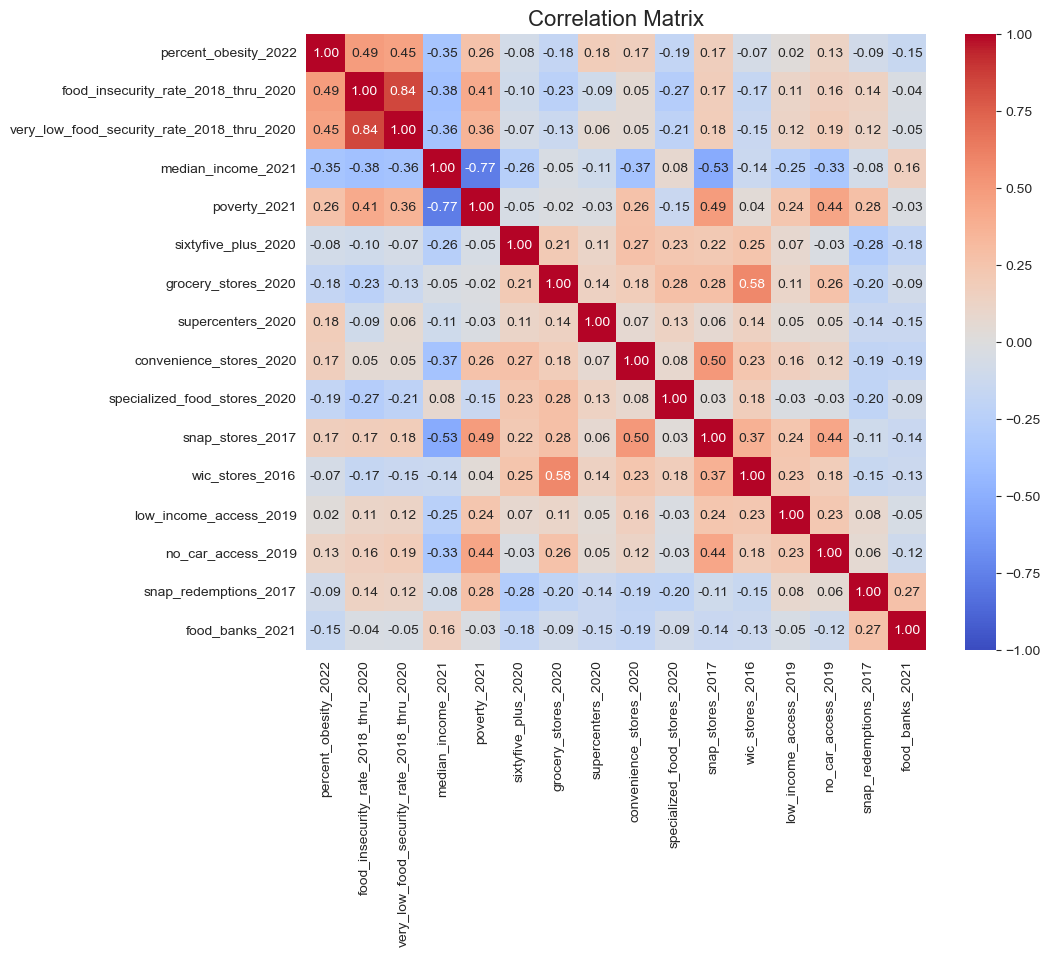

In [24]:
full = df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(
    full,  
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    cbar=True,
    vmin=-1, vmax=1
)
plt.title("Correlation Matrix", fontsize=16)
plt.show()

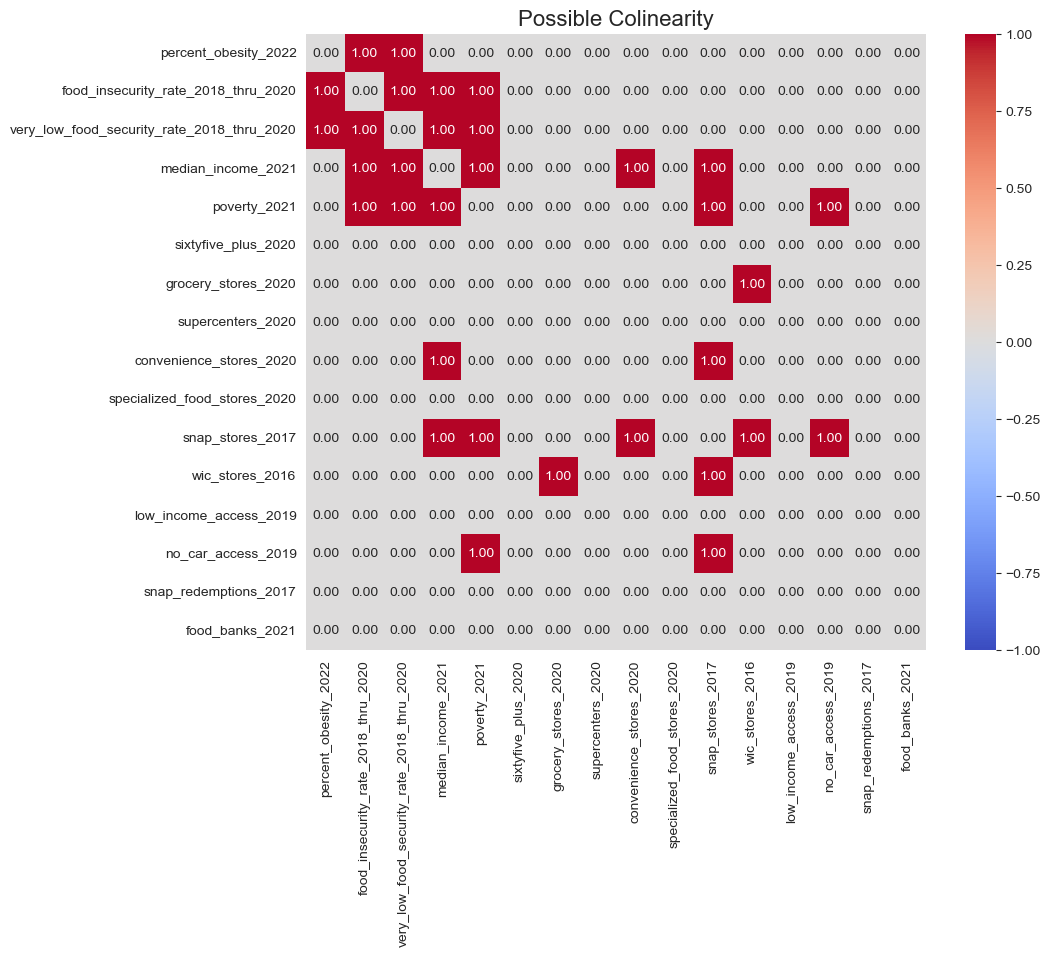

In [25]:
possible_colinearity = full.map(lambda x: 1 if abs(x) > .35 and x != 1 else 0)
plt.figure(figsize=(10,8))
sns.heatmap(
    possible_colinearity,  
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    cbar=True,
    vmin=-1, vmax=1
)
plt.title("Possible Colinearity", fontsize=16)
plt.show()

Heatmaps can also be used to perform some initial exploration between variables. 

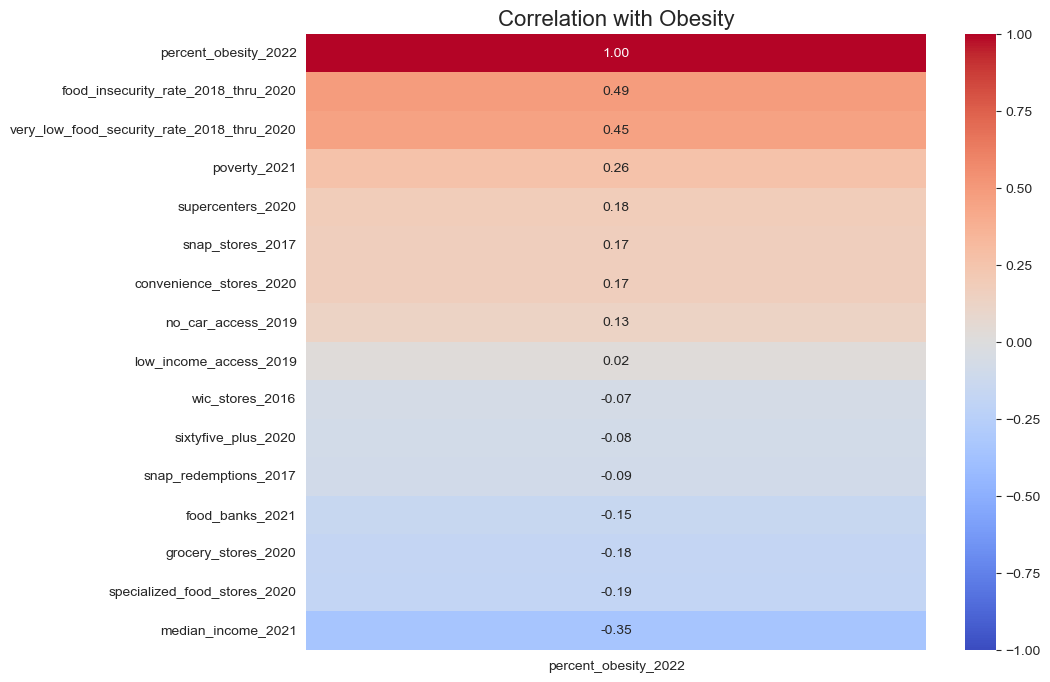

In [26]:
obesity_corr_matrix = df.corr().sort_values(percent_obesity, ascending=False)
plt.figure(figsize=(10,8))
sns.heatmap(
    obesity_corr_matrix[[percent_obesity]],  
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    cbar=True,
    vmin=-1, vmax=1
)
plt.title("Correlation with Obesity", fontsize=16)
plt.show()

### Exploratory Analysis

Before proceeding with analysis, some initial exploration was done. Each row of data was identified as food desert or not based on the variable poverty_2021 being greather than or equal to 20% (per usda) and food_insecurity_rate_2018_thru_2020 being greater than or equal to the median 11.2%.  This was done to explore the initial assumption that obesity rates may be higher in food deserts versus non food deserts.

In [27]:
df['poverty_2021'].describe()

count    3144.000000
mean       14.608707
std         5.661551
min         2.900000
25%        10.600000
50%        13.600000
75%        17.525000
max        43.900000
Name: poverty_2021, dtype: float64

In [28]:
df['food_insecurity_rate_2018_thru_2020'].describe()

count    3144.000000
mean       11.094179
std         2.174904
min         5.700000
25%         9.700000
50%        11.200000
75%        12.600000
max        15.300000
Name: food_insecurity_rate_2018_thru_2020, dtype: float64

In [29]:
df['food_insecurity_rate_2018_thru_2020'].median()

11.2

Create the flag for food desert or not food desert.

In [30]:
df['food_desert_flag'] = (
    (df['poverty_2021'] >= 20) &
    (df['food_insecurity_rate_2018_thru_2020'] >= 11.2)
).astype(int)

In [31]:
df['food_desert_flag'].value_counts()

food_desert_flag
0    2804
1     340
Name: count, dtype: int64

340 rows were identified as food deserts. Compare group means, and then plot the results.

In [32]:
df.groupby('food_desert_flag')['percent_obesity_2022'].mean()

food_desert_flag
0    34.941084
1    37.543529
Name: percent_obesity_2022, dtype: float64

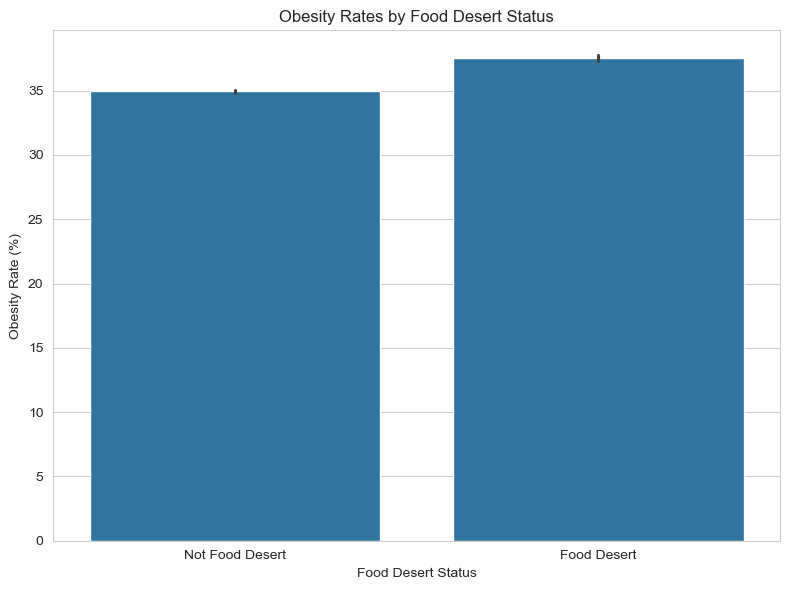

In [33]:
df['food_desert_flag'] = df['food_desert_flag'].astype(int)

plt.figure(figsize=(8, 6))

sns.barplot(
    data=df,
    x='food_desert_flag',
    y='percent_obesity_2022',
    errorbar=('ci', 95)   # updated syntax
)

plt.xticks([0, 1], ['Not Food Desert', 'Food Desert'])
plt.xlabel("Food Desert Status")
plt.ylabel("Obesity Rate (%)")
plt.title("Obesity Rates by Food Desert Status")
plt.tight_layout()

plt.show()

The initial exploration demonstrates that in non-food deserts, the obesity rate was about 34.9%. In food deserts, the obesity rate was 37.5%. This indicates that obesity rates tend to be higher in areas that are considered food deserts. This exploratory analysis used two variables, poverty and food insecurity rate, to flag each row as food desert or not. There is not a set definition for food deserts, many sources define them in different ways. This intital exploration shows there is value in exploring how the components of a food desert may impact obesity. 

## Investigating Needed Tranformations

The project then explored variables to see if transformation were needed. Because of the number of variables, a multivariable approach was used.

Check for skewness.
- Skew = 0 indicates perfectly symmetric distribution
- Skew >0 indicates right-skewed (long tail to the right)
- Skew <0 indicates left-skewed (long tail to the left)

In [34]:
predictors = [food_insecurity_rate, very_low_food_security_rate, median_income, poverty_rate,
              percent_65_plus, low_income_access, no_car_access, snap_redemptions,
              food_banks, specialized_food_stores, grocery_stores, convenience_stores, 
              supercenters, snap_stores, wic_stores]

In [35]:
skewness = df[predictors].skew().sort_values(ascending=False)
print("Highly skewed predictors:\n", skewness[skewness>=3])

Highly skewed predictors:
 no_car_access_2019              7.322988
specialized_food_stores_2020    4.597434
grocery_stores_2020             4.302951
wic_stores_2016                 4.269194
convenience_stores_2020         3.202634
food_banks_2021                 3.142764
supercenters_2020               3.038311
dtype: float64


This could mean a small number of counties or states in the dataset have very highly values. Will explore log transformation of the variables.

In [36]:
print("Moderately skewed predictors:\n", skewness[(skewness<3) & (skewness>=1)])

Moderately skewed predictors:
 snap_stores_2017          2.432736
low_income_access_2019    2.325418
median_income_2021        1.354395
poverty_2021              1.158532
dtype: float64


These values are still skewed but not as severe as noted above. Will explore log transformation if the scatterplots vs obesity show curvature. 


In [37]:
print("Low skew predictors:\n", skewness[(skewness<1)])

Low skew predictors:
 snap_redemptions_2017                         0.898054
sixtyfive_plus_2020                           0.671151
food_insecurity_rate_2018_thru_2020           0.030248
very_low_food_security_rate_2018_thru_2020   -0.112297
dtype: float64


These distributions appear fairly symmetric and can be left as is for regression.

#### Histograms

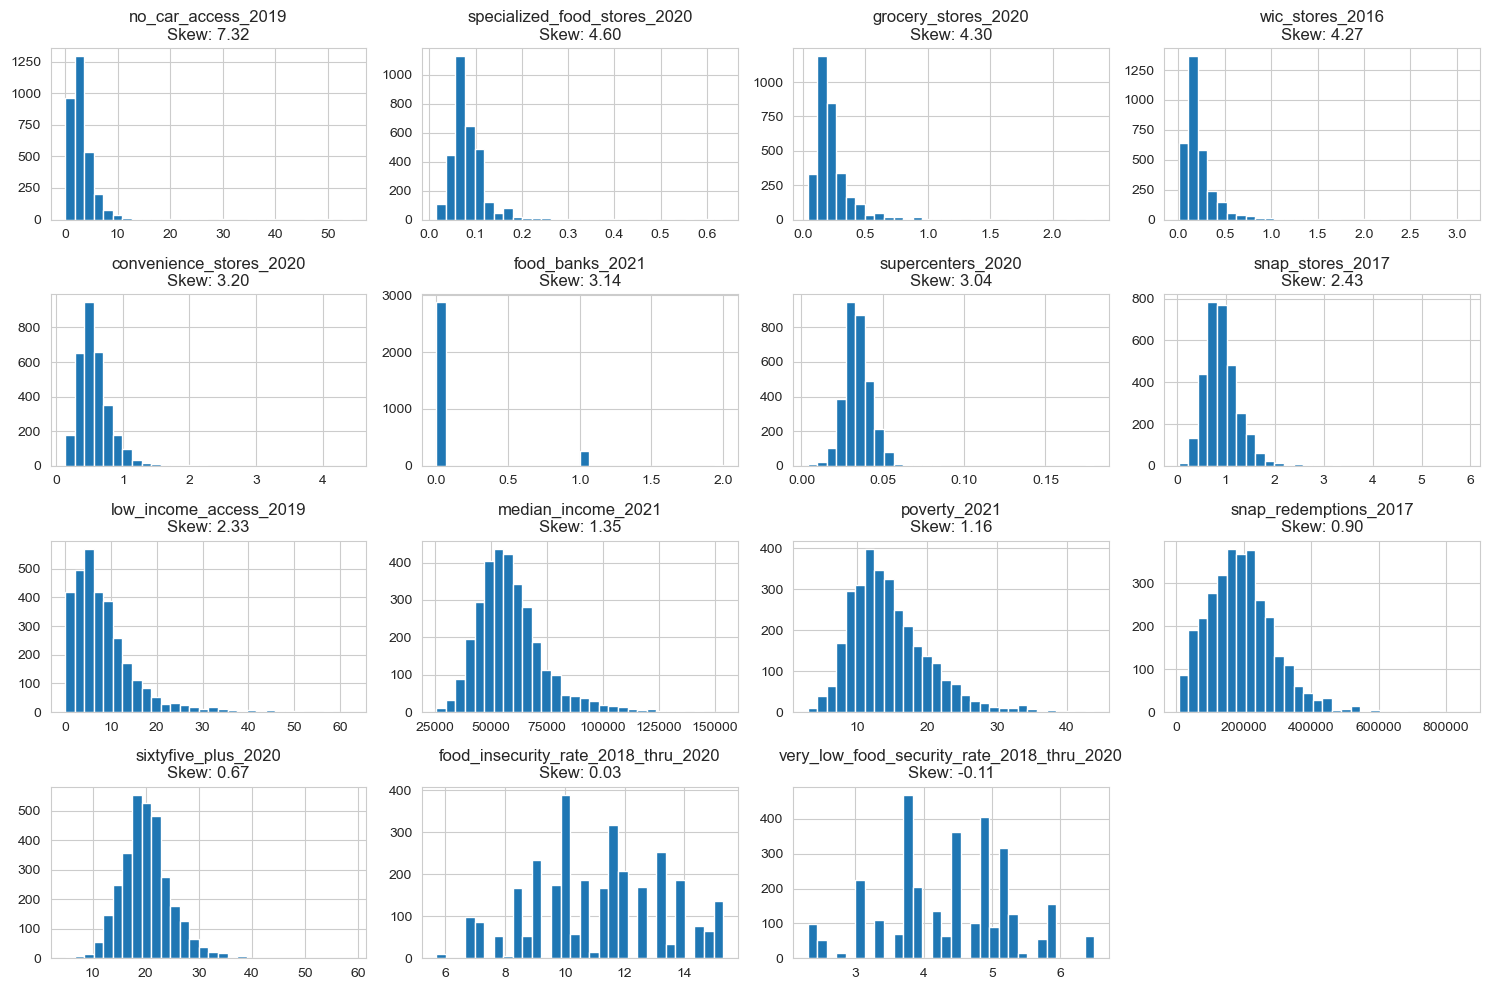

In [38]:
plt.figure(figsize=(15,10))
for i, col in enumerate(skewness.index, 1):
    plt.subplot(4, 4, i)
    df[col].hist(bins=30)
    plt.title(f"{col}\nSkew: {skewness[col]:.2f}")
plt.tight_layout()
plt.show()

The histograms above visually demonstrate the skewness of the variables. In the distribution above it appears that food banks are distributed as either there is a food bank or there is not a food bank. This will be explored further in the transformations section.

#### Scatterplots

Scatterplots vs outcomes to check for linearity

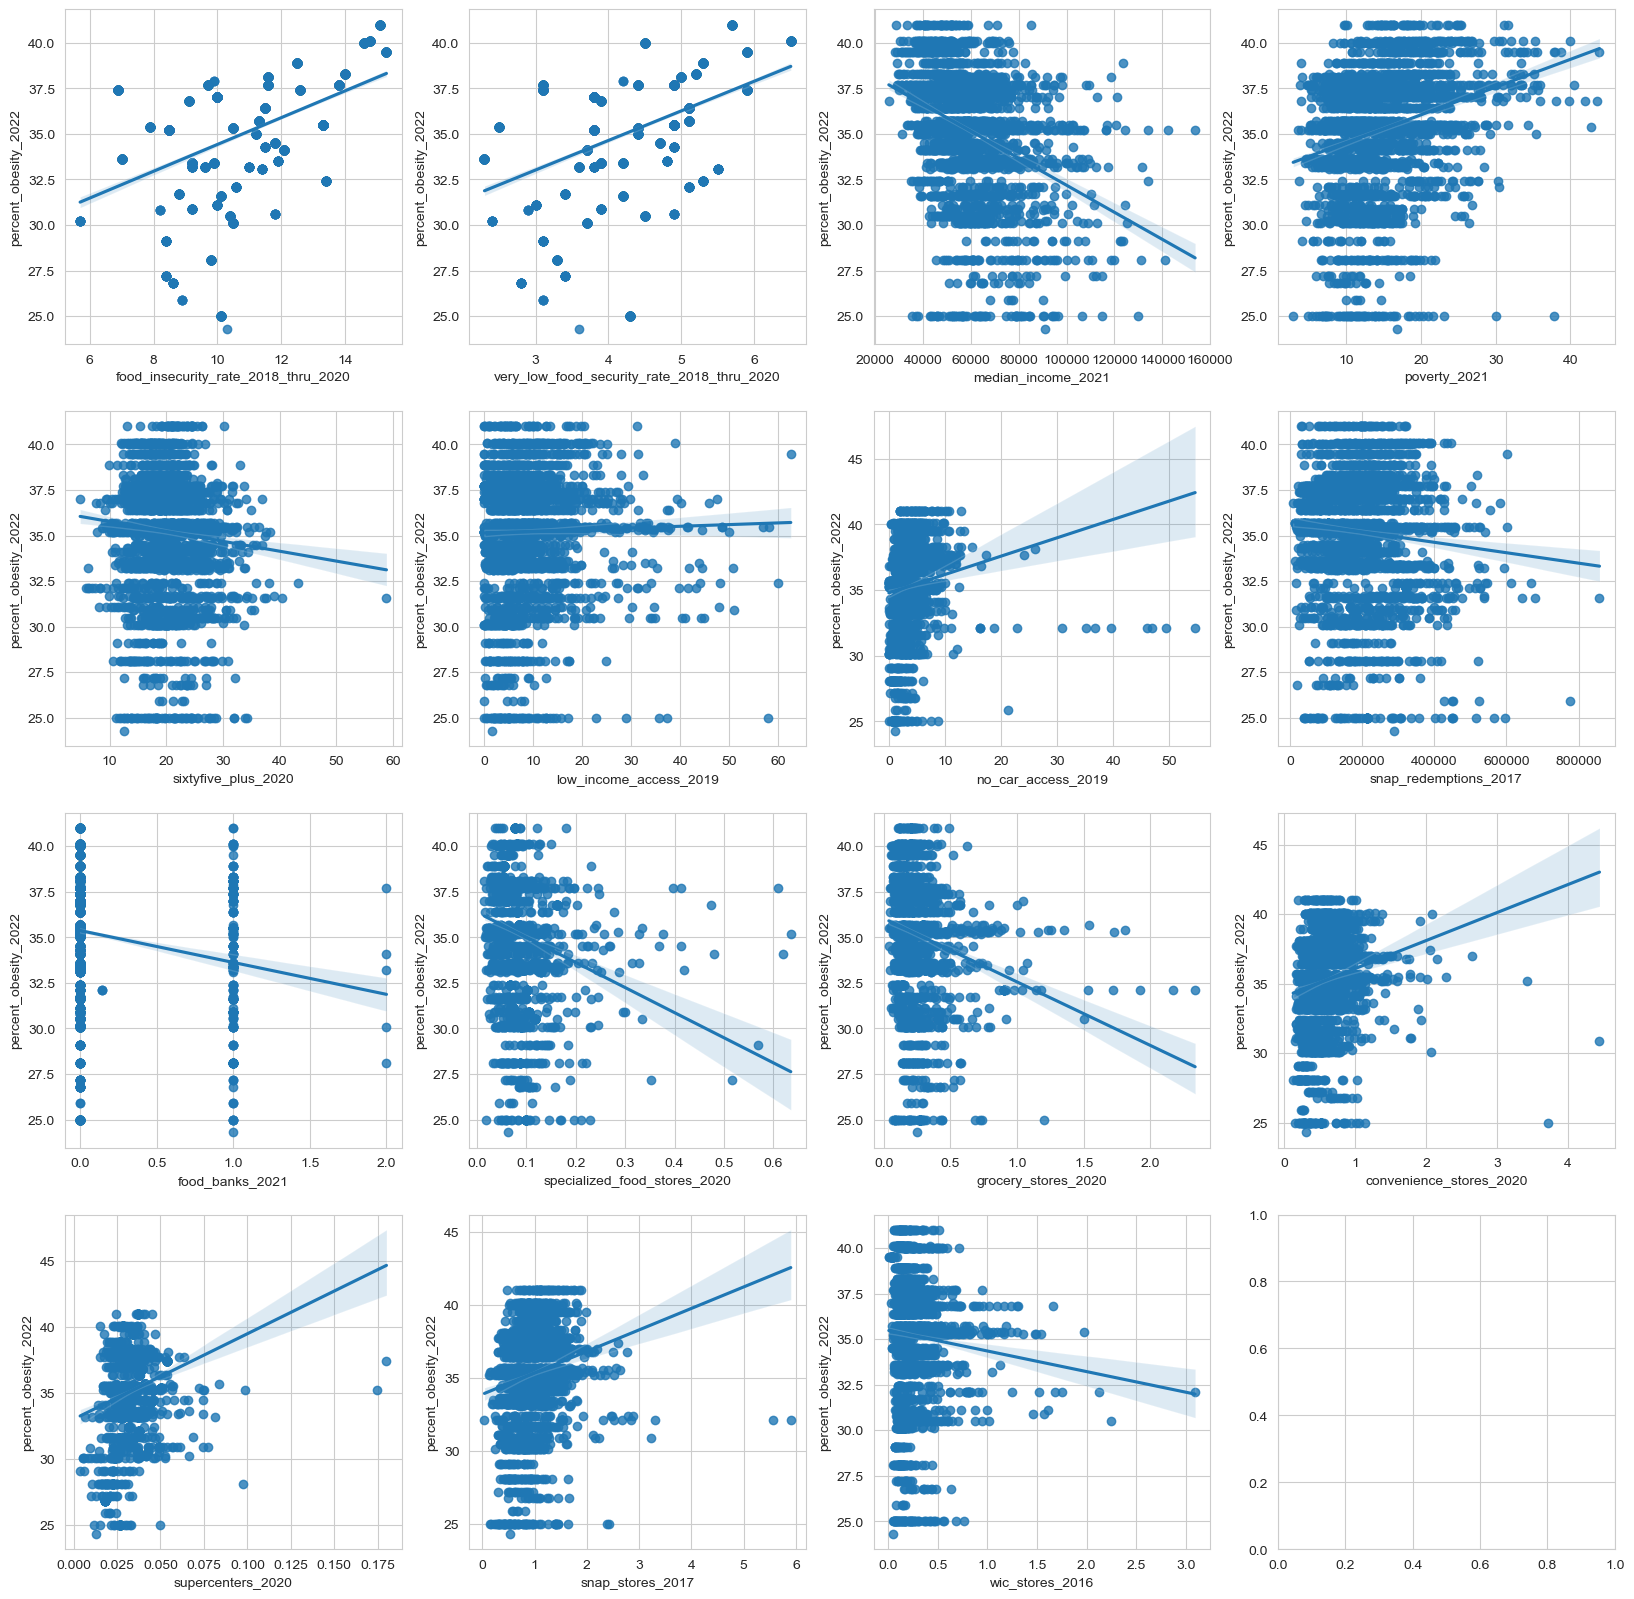

In [39]:
y_variable = obesity
x_variables = predictors

# Create the figure and a set of subplots
fig, axes = plt.subplots(4, 4, figsize=(20, 20))
axes = axes.flatten()

# Loop through the y-variables and plot on each axis
for i, x_var in enumerate(x_variables):
    sns.regplot(data=df, x=x_var, y=y_variable, ax=axes[i])

Summary:

We have taken a preliminary look at predictors by measuring their skewness and then visualizing it via plots. We have identified some potential transformations in the categories below.

Highly skewed and need to investigate transformations
- no_car_access_2019              7.322988
- specialized_food_stores_2020    4.597434
- grocery_stores_2020             4.302951
- wic_stores_2016                 4.269194
- convenience_stores_2020         3.202634
- supercenters_2020               3.038311

Moderately skewed, transformation could help
- snap_stores_2017          2.432736
- low_income_access_2019    2.325418
- median_income_2021        1.354395
- poverty_2021              1.158532

Low skew:
- snap_redemptions_2017                         0.898054
- sixtyfive_plus_2020                           0.671151
- food_insecurity_rate_2018_thru_2020           0.030248
- very_low_food_security_rate_2018_thru_2020   -0.112297

Change to categorical variable:
- food_banks_2021               

## Transform Data

Apply log transformation to highly skewed variables. A constant is added to each to prevent log(0).

In [40]:
skewed_cols = [
    'snap_redemptions_2017',
    'no_car_access_2019',
    'snap_stores_2017',
    'wic_stores_2016',
    'specialized_food_stores_2020',
    'grocery_stores_2020',
    'convenience_stores_2020',
    'supercenters_2020'
]

In [41]:
log_constants = {
    'snap_redemptions_2017': 1,
    'no_car_access_2019': 0.01,
    'snap_stores_2017': 1,
    'wic_stores_2016': 1,
    'specialized_food_stores_2020': 1,
    'grocery_stores_2020': 1,
    'convenience_stores_2020': 1,
    'supercenters_2020': 1
}

for col in skewed_cols:
    df[col + '_log'] = np.log(df[col] + log_constants[col])

Check for skewness after transformation.

In [42]:
print(df[[c + '_log' for c in skewed_cols]].skew())

snap_redemptions_2017_log          -1.015700
no_car_access_2019_log             -1.842688
snap_stores_2017_log                0.645988
wic_stores_2016_log                 2.552148
specialized_food_stores_2020_log    3.676094
grocery_stores_2020_log             2.695504
convenience_stores_2020_log         1.243953
supercenters_2020_log               2.661075
dtype: float64


The skewness has been reduced for several variables, it is still moderately high for specialized food stores, wic stores, and grocery stores.

## Food bank categorical variable

Create food banks categorical variable to indicate if there are food banks present or not. Then confirm the change went through with .unique(). 

In [43]:
df[food_banks].unique()

array([0.        , 1.        , 0.14285714, 2.        ])

The .14 value is a result of imputing by state. 

In [44]:
df['food_banks_present'] = (df['food_banks_2021'] > 0).astype(int)

In [45]:
df['food_banks_present'] = df['food_banks_present'].astype('category')

In [46]:
df['food_banks_present'].unique()

[0, 1]
Categories (2, int64): [0, 1]

## Model Data 1
This is being performed to see how applying the log transformation impacted the fit and residuals of the model.

In [47]:
df.columns

Index(['percent_obesity_2022', 'food_insecurity_rate_2018_thru_2020',
       'very_low_food_security_rate_2018_thru_2020', 'median_income_2021',
       'poverty_2021', 'sixtyfive_plus_2020', 'grocery_stores_2020',
       'supercenters_2020', 'convenience_stores_2020',
       'specialized_food_stores_2020', 'snap_stores_2017', 'wic_stores_2016',
       'low_income_access_2019', 'no_car_access_2019', 'snap_redemptions_2017',
       'food_banks_2021', 'food_desert_flag', 'snap_redemptions_2017_log',
       'no_car_access_2019_log', 'snap_stores_2017_log', 'wic_stores_2016_log',
       'specialized_food_stores_2020_log', 'grocery_stores_2020_log',
       'convenience_stores_2020_log', 'supercenters_2020_log',
       'food_banks_present'],
      dtype='object')

In [48]:
model = smf.ols(
    "percent_obesity_2022 ~ "
    "snap_redemptions_2017_log + "
    "no_car_access_2019_log + "
    "snap_stores_2017_log + "
    "wic_stores_2016_log + "
    "specialized_food_stores_2020_log + "
    "grocery_stores_2020_log + "
    "convenience_stores_2020_log + "
    "supercenters_2020_log + "
    "food_banks_present + "
    "low_income_access_2019 + "
    "median_income_2021 + "
    "poverty_2021 + "
    "sixtyfive_plus_2020 + "
    "food_insecurity_rate_2018_thru_2020 + "
    "very_low_food_security_rate_2018_thru_2020",
    data=df
).fit()

print(model.summary())

                             OLS Regression Results                             
Dep. Variable:     percent_obesity_2022   R-squared:                       0.399
Model:                              OLS   Adj. R-squared:                  0.397
Method:                   Least Squares   F-statistic:                     138.7
Date:                  Tue, 02 Dec 2025   Prob (F-statistic):               0.00
Time:                          19:31:33   Log-Likelihood:                -7380.2
No. Observations:                  3144   AIC:                         1.479e+04
Df Residuals:                      3128   BIC:                         1.489e+04
Df Model:                            15                                         
Covariance Type:              nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

The r-squared is .399, which indicates the model can explain about 40% of the data. Snap_Stores 2017 is not significant. Additionally, as noted with the correlation matrix there may be strong multicollinearity present. Now look at the residuals.

# Residuals and fitted values


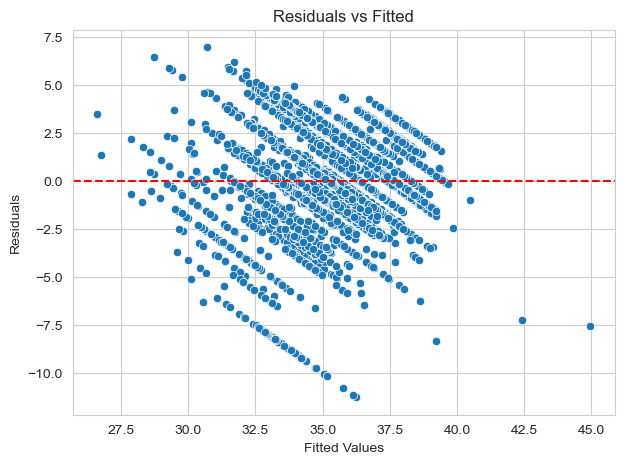

In [49]:
residuals = model.resid
fitted = model.fittedvalues

plt.figure(figsize=(7,5))
sns.scatterplot(x=fitted, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted")
plt.show()

The residuals plot shows heteroscedasticity. They increase in spread as the fitted values increase, creating the diagonal and fan-like shape above. This indicates the need for more transformations.

Check for heteroscedasticity using Breusch-Pagan test.

In [50]:
from statsmodels.stats.diagnostic import het_breuschpagan
bp_test = het_breuschpagan(model.resid, model.model.exog)
bp_test

(np.float64(235.19397845761276),
 np.float64(1.3746384479713342e-41),
 np.float64(16.861139568766365),
 np.float64(2.441766675142632e-43))

The values are far below 0.05, which means we reject the null hypothesis of homoscedasticity. The model has significant heteroscedasticity. This matches what was observed in the residual vs fitted plot. 

This project will use stepwise regression and elastic net for modeling. OLS assumes linearity, homoscedasticity, and no multicollinearity. Elastic net does not require homoscedasticity and is designed to better handle multicollinearity. It focuses on prediction, not unbiased estimation. 

### Stepwise Regression
Stepwise regressions is a method for constructing the optimal subset of linear regression predictors.

Start by defining our input our output.

In [51]:
X = df.iloc[:,2:]
X = X.drop(columns=snap_redemptions)
Y_obesity = df.iloc[:,0]
Y_diabetes =df.iloc[:,1]

We will use linear regression and step forward by default--meaning add predictors--scoring by resulting model by accuracy of r^2 by default. Recall r^2 is the proportion RegSS (regression sum of squares, or variance in data explained by the regression model) over the TSS (total sum of squares, or variance in the data). A higher r^2 is preferrable. mlxtend does not support adjusted r^2. The best three features will be kept.

In [52]:
sfs = SequentialFeatureSelector(linear_model.LinearRegression(), k_features=6)
sfs.fit(X, Y_obesity)
feature_names = sfs.k_feature_names_

Now we will split our data into training and testing subsets. Test will be 25% percent of our overall set. Transform the data to only include the attributes selected.

In [53]:
X_obesity_train, X_obesity_test, Y_obesity_train, Y_obesity_test = train_test_split(X, Y_obesity, test_size=0.25, random_state=33)
X_obesity_train_sfs = sfs.transform(X_obesity_train)
X_obesity_test_sfs = sfs.transform(X_obesity_test)

Re-run the linear model with only training data.

In [54]:

model_string = obesity + " ~ " + " + ".join(feature_names)

model_selected = smf.ols(formula=model_string, data=df).fit()
print(model_selected.summary())

lr_selected = linear_model.LinearRegression()
lr_selected.fit(X_obesity_train_sfs, Y_obesity_train)
lr_selected

                             OLS Regression Results                             
Dep. Variable:     percent_obesity_2022   R-squared:                       0.331
Model:                              OLS   Adj. R-squared:                  0.330
Method:                   Least Squares   F-statistic:                     259.2
Date:                  Tue, 02 Dec 2025   Prob (F-statistic):          7.37e-270
Time:                          19:31:40   Log-Likelihood:                -7548.8
No. Observations:                  3144   AIC:                         1.511e+04
Df Residuals:                      3137   BIC:                         1.515e+04
Df Model:                             6                                         
Covariance Type:              nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

LinearRegression()

Evaluate the model by r^2 for both the training and testing data.

In [55]:
r_squared_obesity_train = lr_selected.score(X_obesity_train_sfs, Y_obesity_train)
r_squared_obesity_test = lr_selected.score(X_obesity_test_sfs, Y_obesity_test)
print("R squared for model obesity using training data: " + str(r_squared_obesity_train))
print("R squared for model obesity using testing data: " + str(r_squared_obesity_test)) #this should show


R squared for model obesity using training data: 0.3429280140825828
R squared for model obesity using testing data: 0.2900296839323152


The stepwise regression analysis selected six variables as significant predictors of obesity rates: very low food security rate, median income, percent age 65+, SNAP redemptions, grocery store density, and supercenter density. The direction of the effects aligns with expectations: food insecurity was associated with higher obesity, while higher income, SNAP participation, and greater grocery store availability were linked to lower obesity. Supercenters did not align with what was anticipated, but may be a result of dietary patterns of chain food stores. All predictors were significant. However, diagnostic tests indicated multicollinearity, suggesting instability in the model. These issues motivate the use of Elastic Net, which is better suited to handling correlated socioeconomic and food-access variables.

## Elastic Net

Split between the features and the target (obesity). We will keep the original variables as well as use the log-transformed variables. We will exclude the original versions of the log variables.

In [56]:
predictors = [
    'food_insecurity_rate_2018_thru_2020',
    'very_low_food_security_rate_2018_thru_2020',
    'median_income_2021',
    'poverty_2021',
    'sixtyfive_plus_2020',
    'low_income_access_2019',
    'food_banks_present',
    'snap_redemptions_2017_log',
    'no_car_access_2019_log',
    'snap_stores_2017_log',
    'wic_stores_2016_log',
    'specialized_food_stores_2020_log',
    'grocery_stores_2020_log',
    'convenience_stores_2020_log',
    'supercenters_2020_log'
]

Define the features

In [57]:
X = df[predictors]

Define the target

In [58]:
y = df['percent_obesity_2022']

Split the data.

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Scale features.

In [60]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Fit elastic net with CV

In [61]:
elastic_net = ElasticNetCV(
    cv=5,                # 5-fold cross-validation  
    random_state=42
)
elastic_net.fit(X_train_scaled, y_train)

ElasticNetCV(cv=5, random_state=42)

Print coefficients

In [62]:
coef_dict = dict(zip(X.columns, elastic_net.coef_))
print("Elastic Net coefficients:")
for feature, coef in coef_dict.items():
    print(f"{feature}: {coef:.4f}")

Elastic Net coefficients:
food_insecurity_rate_2018_thru_2020: 1.0589
very_low_food_security_rate_2018_thru_2020: 0.2718
median_income_2021: -0.7544
poverty_2021: -0.3458
sixtyfive_plus_2020: -0.5474
low_income_access_2019: -0.2395
food_banks_present: -0.2110
snap_redemptions_2017_log: -0.3994
no_car_access_2019_log: 0.2306
snap_stores_2017_log: -0.0152
wic_stores_2016_log: 0.1334
specialized_food_stores_2020_log: -0.2211
grocery_stores_2020_log: -0.4957
convenience_stores_2020_log: 0.4617
supercenters_2020_log: 0.5974


The strongest positive predictors of obesity in the Elastic Net model were food insecurity rate, supercenters (log), convenience stores (log), very low food security rate, no car access (log), and WIC stores (log). Among these, food insecurity rate had the largest positive coefficient, indicating it has the strongest association with higher obesity rates when all other variables are held constant.

The strongest negative predictors were median income, percent aged 65+, grocery stores, poverty, SNAP redemptions, low-income access, specialized food stores, and presence of food banks. These variables were associated with lower predicted obesity rates after accounting for the other features in the model.

Additionally, SNAP stores (log) had a coefficient close to zero, suggesting it contributed very little to the model’s predictive power.

Model Performance

In [63]:
r2_train = elastic_net.score(X_train_scaled, y_train)
r2_test = elastic_net.score(X_test_scaled, y_test)
print(f"\nR2 Train: {r2_train:.3f}")
print(f"R2 Test: {r2_test:.3f}")


R2 Train: 0.396
R2 Test: 0.408


The Elastic Net model achieved an R-squared of 0.396 on the training set and 0.408 on the test set, indicating that the model explains approximately 40% of the variance in obesity rates. The similarity between training and test R² values suggests that the model generalizes well and is not overfitting. However, the R-squared value is still relatively low, indicating the model does not fit well.

Plot feature importance. This will visually show the coefficients.

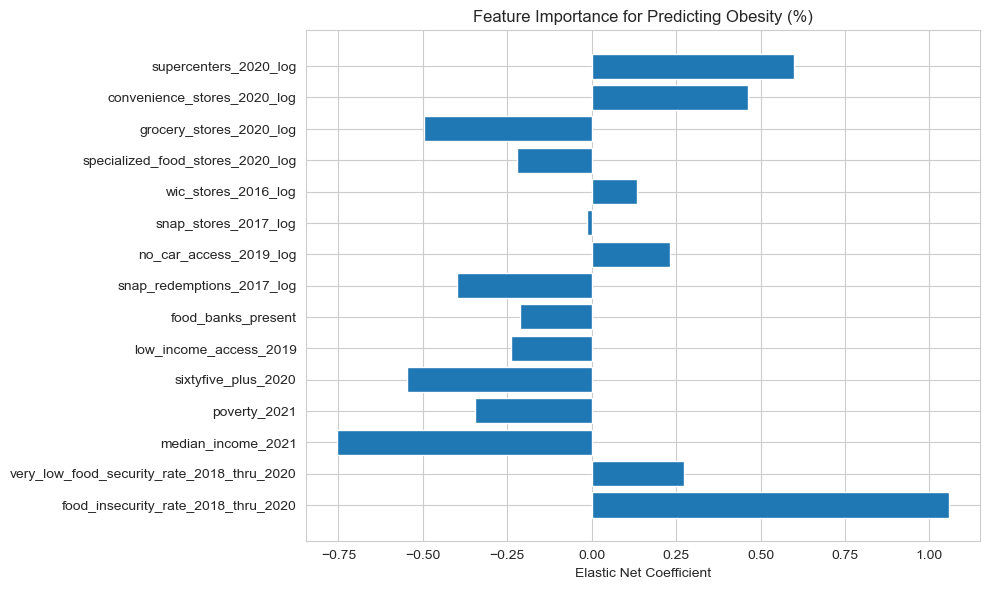

In [64]:
plt.figure(figsize=(10,6))
plt.barh(list(coef_dict.keys()), coef_dict.values())
plt.xlabel("Elastic Net Coefficient")
plt.title("Feature Importance for Predicting Obesity (%)")
plt.tight_layout()
plt.show()

Counties with higher food insecurity rates show the strongest positive association with obesity, followed by higher convenience store and supercenter density; in contrast, higher median income and greater numbers of grocery stores are linked to lower obesity rates.

Overall, socioeconomic harship and limited access to nutritious food options appear to be the strongest predictors in the elastic-net model, and the coefficient shrinkage suggests this model is appropriate for handling the multicollinearity present in these access-related variables.

Plot the residuals 

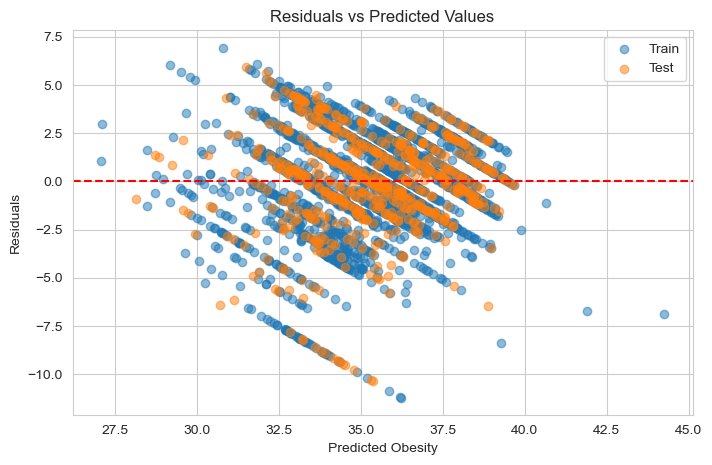

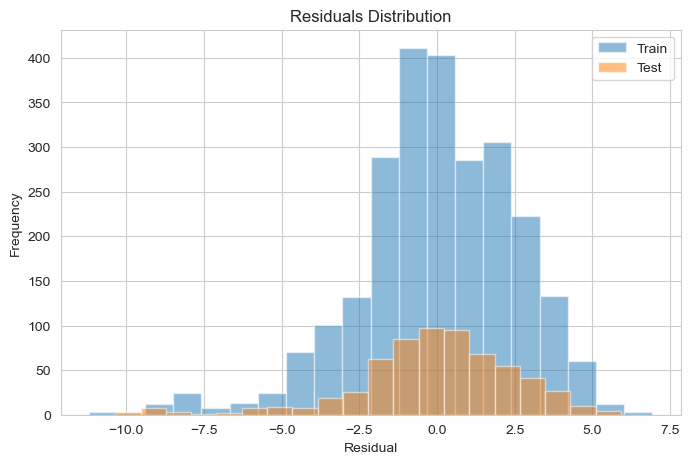

In [65]:
y_train_pred = elastic_net.predict(X_train_scaled)
y_test_pred = elastic_net.predict(X_test_scaled)

residuals_train = y_train - y_train_pred
residuals_test = y_test - y_test_pred


plt.figure(figsize=(8,5))
plt.scatter(y_train_pred, residuals_train, alpha=0.5, label='Train')
plt.scatter(y_test_pred, residuals_test, alpha=0.5, label='Test')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Obesity')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.legend()
plt.show()

plt.figure(figsize=(8,5))
plt.hist(residuals_train, bins=20, alpha=0.5, label='Train')
plt.hist(residuals_test, bins=20, alpha=0.5, label='Test')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Residuals Distribution')
plt.legend()
plt.show()


The residuals cluster evenly around zero with no strong curved pattern. This suggest that the elastic net model is capturing the main linear structure of the relationship between predictors and obesity.

Both train and test residual distributions are roughly centered and bell-shaped; this indicates the model generalizes reasonably well without overfitting.

The slight funneling at higher predicted obesity values hints at mild jeteroscedasticity, but not enough to undemrine the model's overall fit.

## VIF

We will check for multicollinearity again using the Variance Inflation Factor, which will tell us which variables are highly collinear. In the code below, we want to look at X, which is the variable we used to store all the predictor variables.

In [66]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data.sort_values(by='VIF', ascending=False))


                                       feature         VIF
7                    snap_redemptions_2017_log  185.583659
0          food_insecurity_rate_2018_thru_2020  107.061211
1   very_low_food_security_rate_2018_thru_2020   89.815471
2                           median_income_2021   44.448433
9                         snap_stores_2017_log   28.936723
3                                 poverty_2021   26.996504
4                          sixtyfive_plus_2020   24.610108
14                       supercenters_2020_log   16.968246
13                 convenience_stores_2020_log   15.110201
12                     grocery_stores_2020_log    7.785847
11            specialized_food_stores_2020_log    6.663326
10                         wic_stores_2016_log    6.053657
8                       no_car_access_2019_log    2.748520
5                       low_income_access_2019    2.617841
6                           food_banks_present    1.245201


When applying VIF, generally a VIF greater than 10 is considered as strong multicollinearity present. A VIF between 5 and 10 presents moderate concern for multicollinearity. Less than 5 is acceptable. 

In the above output, the following variables have a VIF greater than 10 and present high multicollinearity:
snap_redemptions_2017_log  185.583659
- food_insecurity_rate_2018_thru_2020  107.061211
- very_low_food_security_rate_2018_thru_2020   89.815471
- median_income_2021   44.448433
- snap_stores_2017_log   28.936723
- poverty_2021   26.996504
- sixtyfive_plus_2020   24.610108
- supercenters_2020_log   16.968246
- convenience_stores_2020_log   15.110201

Grocery stores, specialized food stores, and wic stores have scores between 5 and 10 and will be kept due to having moderate scores.

No car access, low income access, and food banks present have low VIF and are fine to keep.

Each variable was reviewed to determine if it should be kept or removed based on VIF, coefficient size. A high VIF indicates a vaiable is strongly correlated with other predictors, but not necessarily lacking predictive power. 

Drop:

- snap redemptions: extremely high VIF, possibly redundant with food insecurity and income. Also has small effect
- very lower food scurity rate: High VIF, smaller coefficient, possibly redundant
- snap stores (log): Small coefficient, low predictive power
- poverty rate: likely collinear with median income, redundant and has high VIF

Keep:

- food insecurity rate: Strong positive predictor, theoretically important for food hardship. 
- median income: strong predictor, theoretically important socioeconomic variable
- Sixty five plus: Demographic variable; interpretable; important for context
- supercenters (log): Positive predictor; interpretable; captures large store food environment
- convenience stores (log): Positive predictor; interpretable; represents access to calorie-dense foods
- grocery stores (log):Negative predictor; interpretable; captures healthy food access. Moderate VIF
- specialized food stores (log): Moderate predictor; interpretable; may combine with grocery stores conceptually. Moderate VIF
- WIC stores (log): small positive coefficient but moderate VIF
- No car access (log): Low VIF; interpretable; positive effect consistent with economic hardship
- low income access: Low VIF; interpretable; protective effect
- food banks present: Low VIF; interpretable; represents community support

## Remove identified variables and re-run elastic net model

Identify predictors we will keep

In [67]:
keep_predictors = [
    'food_insecurity_rate_2018_thru_2020',
    'median_income_2021',
    'sixtyfive_plus_2020',
    'supercenters_2020_log',
    'convenience_stores_2020_log',
    'grocery_stores_2020_log',
    'specialized_food_stores_2020_log',
    'no_car_access_2019_log',
    'low_income_access_2019',
    'food_banks_present',
    'wic_stores_2016_log' 
]

X_reduced = df[keep_predictors]
y = df['percent_obesity_2022']


Split and scale.

In [68]:
X_train, X_test, y_train, y_test = train_test_split(
    X_reduced, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Re-run elastic net model

In [69]:
elastic_net = ElasticNetCV(
    cv=5,
    l1_ratio=[0.1, 0.5, 0.9, 1.0],
    random_state=42
)
elastic_net.fit(X_train_scaled, y_train)

ElasticNetCV(cv=5, l1_ratio=[0.1, 0.5, 0.9, 1.0], random_state=42)

Check coefficients and model fit

In [70]:
from sklearn.metrics import r2_score

In [71]:
coef_dict = dict(zip(X_reduced.columns, elastic_net.coef_))
for feature, coef in coef_dict.items():
    print(f"{feature}: {coef:.4f}")

r2_train = elastic_net.score(X_train_scaled, y_train)
r2_test = elastic_net.score(X_test_scaled, y_test)
print(f"\nR2 Train: {r2_train:.3f}")
print(f"R2 Test: {r2_test:.3f}")


food_insecurity_rate_2018_thru_2020: 1.2316
median_income_2021: -0.4201
sixtyfive_plus_2020: -0.3837
supercenters_2020_log: 0.6822
convenience_stores_2020_log: 0.5051
grocery_stores_2020_log: -0.4093
specialized_food_stores_2020_log: -0.2057
no_car_access_2019_log: 0.1843
low_income_access_2019: -0.2642
food_banks_present: -0.2952
wic_stores_2016_log: 0.1035

R2 Train: 0.375
R2 Test: 0.385


R2 Train: 0.396
R2 Test: 0.408

The model fit is slightly worse than before. The original train/test R-sqaured was 0.396 and 0.408. Now the R-squared for train/test is 0.375 and 0.385. This is a slight reduction.

Compared to the original model, the reduced model removes redundant or near-zero predictors, slightly decreasing R-squared from 0.408 to 0.385 on the test set. Food insecurity remains the strongest positive predictor, and supercenters and convenience stores also have notable positive effects. Median income, grocery stores, older adult population, and food banks continue to have protective effects, while minor predictors like WIC stores and low-income access remain small but interpretable.

Plot the outcomes again to visually represent coefficients. 

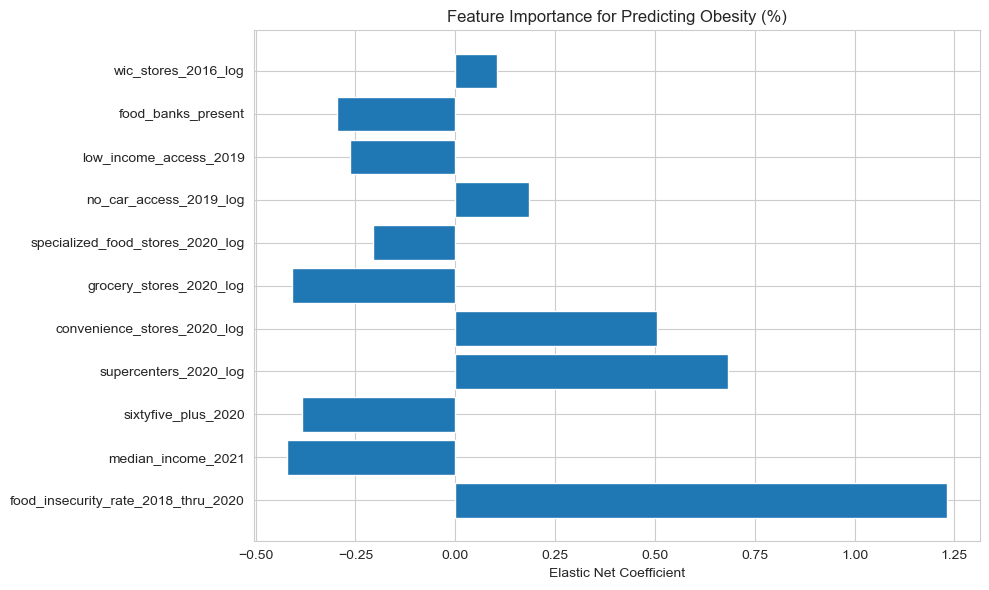

In [72]:
plt.figure(figsize=(10,6))
plt.barh(list(coef_dict.keys()), coef_dict.values())
plt.xlabel("Elastic Net Coefficient")
plt.title("Feature Importance for Predicting Obesity (%)")
plt.tight_layout()
plt.show()

Check residuals again

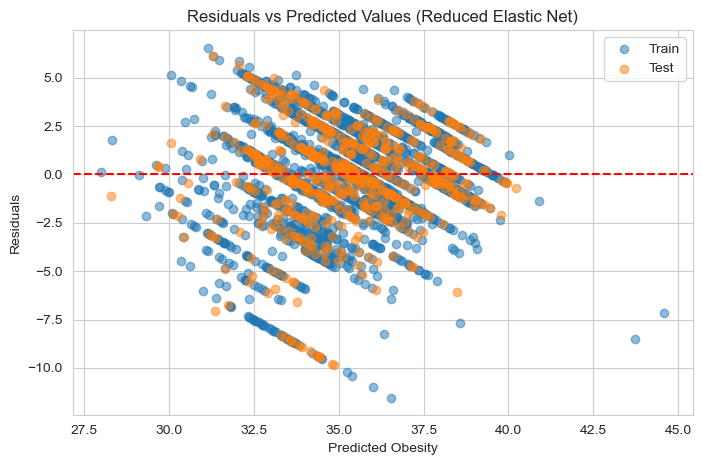

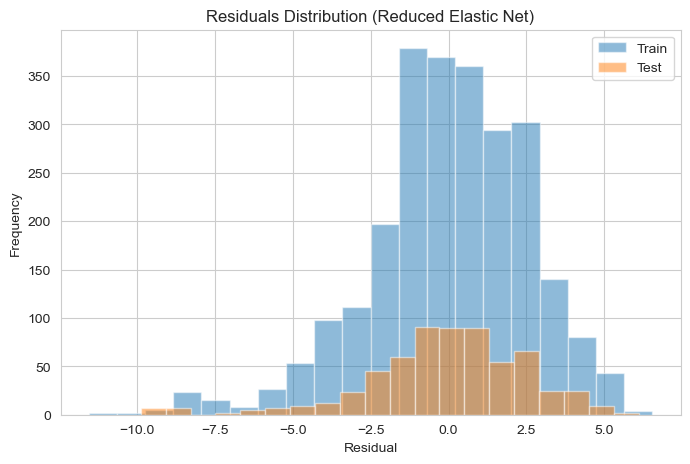

In [73]:

y_train_pred = elastic_net.predict(X_train_scaled)
y_test_pred = elastic_net.predict(X_test_scaled)


residuals_train = y_train - y_train_pred
residuals_test = y_test - y_test_pred


plt.figure(figsize=(8,5))
plt.scatter(y_train_pred, residuals_train, alpha=0.5, label='Train')
plt.scatter(y_test_pred, residuals_test, alpha=0.5, label='Test')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Obesity')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values (Reduced Elastic Net)')
plt.legend()
plt.show()


plt.figure(figsize=(8,5))
plt.hist(residuals_train, bins=20, alpha=0.5, label='Train')
plt.hist(residuals_test, bins=20, alpha=0.5, label='Test')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Residuals Distribution (Reduced Elastic Net)')
plt.legend()
plt.show()


The residuals remain centered around zero with no major curvature, suggesting the reduced elastic net model is still capturing the main linear structure after variable trimming.

The train and test residual distributions overlap closely and maintain a roughly symmetric, bell-shaped form, indicating good generalization and no clear signs of overfitting.

While there is still some mild spread at higher predicted obesity values, the reduced model's residual behavior is overall stable and appropriate for the feature set.

## PCA

The project then implemented PCA. PCA can be used to eliminate multicollinearity, which is present in the model, and improve predictive performance. 

Scale the features

In [74]:
pca = PCA(n_components=0.9)  # keep 90% variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

Fit PCA. Will choose n_components-0.9 to keep 90% of variance.

In [75]:
elastic_net_pca = ElasticNetCV(cv=10, l1_ratio=[0.1,0.3,0.5,0.7,0.9,1.0], random_state=42)
elastic_net_pca.fit(X_train_pca, y_train)

ElasticNetCV(cv=10, l1_ratio=[0.1, 0.3, 0.5, 0.7, 0.9, 1.0], random_state=42)

Fit elastic net using the PCA predictors.

In [76]:
y_train_pred_pca = elastic_net_pca.predict(X_train_pca)
y_test_pred_pca = elastic_net_pca.predict(X_test_pca)

Evaluate r-squared of orginal elastic net versus PCA + elastic net

In [77]:
r2_train_pca = r2_score(y_train, y_train_pred_pca)
r2_test_pca = r2_score(y_test, y_test_pred_pca)

In [78]:
print("Elastic Net (Original Features):")
print(f"  R-squared Train: {r2_train:.3f}, R-squared Test: {r2_test:.3f}\n")

print("Elastic Net + PCA:")
print(f"  R-squared Train: {r2_train_pca:.3f}, R-squared Test: {r2_test_pca:.3f}")

Elastic Net (Original Features):
  R-squared Train: 0.375, R-squared Test: 0.385

Elastic Net + PCA:
  R-squared Train: 0.367, R-squared Test: 0.365


Applying elastic net did not change the R-squared values in a meaningful amount.  Applying Elastic Net + PCA explains roughly 37% of the model, which means the PCA reduced multicollinearity but did not improve the predictive power of the dataset.

Examine the loadings and determine which original variables contribute the most to each PC.

In [79]:
loadings = pd.DataFrame(pca.components_.T, 
                        index=X_train.columns, 
                        columns=[f'PC{i+1}' for i in range(pca.n_components_)])

print(loadings)

                                          PC1       PC2       PC3       PC4  \
food_insecurity_rate_2018_thru_2020 -0.060297  0.514104  0.061451 -0.088580   
median_income_2021                  -0.319710 -0.471383 -0.002834  0.026644   
sixtyfive_plus_2020                  0.373996 -0.042007 -0.211636 -0.324185   
supercenters_2020_log                0.207238 -0.069341 -0.382883  0.791155   
convenience_stores_2020_log          0.392765  0.164298 -0.001707 -0.298534   
grocery_stores_2020_log              0.409118 -0.295166  0.258875  0.001308   
specialized_food_stores_2020_log     0.240941 -0.349429 -0.240583 -0.057133   
no_car_access_2019_log               0.163824  0.430918 -0.168341  0.165824   
low_income_access_2019               0.225913  0.207188  0.499276  0.351888   
food_banks_present                  -0.236152 -0.076563  0.531172  0.125433   
wic_stores_2016_log                  0.444962 -0.190329  0.346654  0.031256   

                                          PC5      

Each PC is a weighted combination of the original variables. 

The first principal component places strong positive weight on median income and a strong negative weight on poverty, low-income access, and food insecurity, indicating it captures a broad socioeconomic gradient.

PC2 and PC3 mix store-type variables with access indicators, suggesting they explain smaller, more localized differences in food environment characteristics rather than a single, dominant axis.

Overall, the loadings confirm that the predictors share substantial correlation structure.

PC1 acts at the main socioeconomic-access dimension and later components capture a more nuanced variation across store availability and assistance programs.

## Conclusion

This project examined the relationship between socioeconomic indicators, components associated with food deserts, and obesity using several modeling approaches. The initial model was a stepwise regression, followed by an elastic net regression model. After addressing multicollinearity via Variance Inflation Factor (VIF) assessment, the final model identified several key predictors of obesity rates. Principal Component Analysis (PCA) was also applied but did not meaningfully improve model performance.

The results indicate that food insecurity rate (coefficient = 1.232) had the strongest positive association with obesity, directly reflecting food desert conditions and suggesting that communities with higher food insecurity tend to experience higher obesity rates. Increased access to supercenters (0.682) and convenience stores (0.505) was also positively associated with obesity. The effect of convenience stores aligns with expectations, as these stores often offer less nutritious, highly processed foods with limited variety. The positive association with supercenters was unexpected and may reflect the types of foods available in large chain grocery outlets, which can influence dietary patterns linked to obesity.

Conversely, higher median income (-0.420), a larger proportion of the population aged 65 and older (-0.384), and greater access to grocery stores (-0.409) and specialized food stores (-0.206) were associated with lower obesity rates. These findings suggest that higher socioeconomic status, age demographics, and access to diverse, healthy food options may serve as protective factors against obesity.

Other variables, including food banks presence (-0.295), low-income access (-0.264), and WIC stores (0.104), showed weaker associations but may reflect additional social and structural factors affecting food accessibility and diet quality.

The model explained a moderate proportion of the variance in obesity rates (R-squared Train = 0.375, R-squared Test = 0.385), indicating that while components of food deserts and socioeconomic factors are significant, other behavioral, cultural, and environmental factors likely also contribute to obesity outcomes.

Overall, this project highlights that both food environment characteristics and socioeconomic factors play an important role in understanding and addressing obesity risk in communities. Specifically, it showed that food insecurity had the strongest impact on obesity, while access to grocery stores appeared to have a mitigating effect. The model explained a moderate proportion of the variance in obesity rates, as reflected by the R-squared values, indicating that additional factors beyond those captured in this study likely influence obesity outcomes. Future work could incorporate other measurements or behavioral and environmental variables to improve model fit and better capture the complexity of obesity risk.